# The HFM library - A fast marching solver with adaptive stencils 

## Part : Algorithmic enhancements to the fast marching method
## Chapter : Achieving high accuracy

The present notebook is devoted to achieving high accuracy with the fast marching method. Let us recall that the standard discretization of the eikonal equation, for a problem with a point source, achieves the accuracy
$$
    \mathcal O(h \ln(h) ),
$$
where $h>0$ is the discretization grid scale. This is enough for a number of problems, but insufficient for other applications. 


In order to reduce this error, we use a combination of the three following approaches:
* *Second and third order finite differences* (**order** key). Numerical solvers of eikonal equations typically rely on first order upwind finite differences. Higher order finite differences can however be used at the 'recompute' stage, provided they are complemented with cautious fallback strategies, in view of their instability.
* *Equation factoring at the source(s)* (**factoringMethod** key). The solution of the eikonal equation has a non-differentiable singularity at the source point, which yields inaccurate finite differences in its neighborhood. Equation factoring methods correct for these systematic errors, by relying on an analytical expression of the singularity.
* *Spreading seed information* (**seedRadius** key). By default the seed position is rounded to the closest grid point, producing a systematic $\mathcal O(h)$ error, unless the provided seed falls exactly on a seed point. The seedRadius option replaces the given off-grid seed point with a small set of on-grid seed points equipped analytic estimates of the solution.


Some possible additional difficulties may however cause the above techniques to be inoperant. For instance:
* *Discontinuities in the metric*. Non-smooth data yields non-smooth solutions, which are not amenable to high order methods.
* *Obstacles in the domain* Secondary sources, created by the obstacles, are currently not handled by the equation factoring method. In addition, the fact that these sources are located on the domain boundary creates numerical difficulities.
* *Non holonomic models (curvature penalization)* The solutions to these models have a severe singularity at the source, which generally does not have an analytic expression. In addition, our implementation involves a relaxation, with parameter $\epsilon>0$, which is another source of error.


[**Summary**](Summary.ipynb) of volume Fast Marching Methods, this series of notebooks.

[**Main summary**](../Summary.ipynb) of the Adaptive Grid Discretizations 
	book of notebooks, including the other volumes.

# Table of contents
  * [1. Poincare model of the hyperbolic plane](#1.-Poincare-model-of-the-hyperbolic-plane)
    * [1.1 The seedRadius key](#1.1-The-seedRadius-key)
    * [1.2 (Static) Equation factoring](#1.2-(Static)-Equation-factoring)
    * [1.3 Second order scheme](#1.3-Second-order-scheme)
    * [1.4 Third order scheme, and semi-Lagrangian numerical methods](#1.4-Third-order-scheme,-and-semi-Lagrangian-numerical-methods)
  * [2. A Riemannian metric](#2.-A-Riemannian-metric)
    * [2.1 Trying the various numerical scheme enhancements](#2.1-Trying-the-various-numerical-scheme-enhancements)
  * [3. A Rander metric](#3.-A-Rander-metric)
  * [4. Asymmetric quadratic metrics (TODO)](#4.-Asymmetric-quadratic-metrics-(TODO))
  * [5. Metric arising from seismology. (TODO)](#5.-Metric-arising-from-seismology.-(TODO))



This Python&reg; notebook is intended as documentation and testing for the [HamiltonFastMarching (HFM) library](https://github.com/mirebeau/HamiltonFastMarching), which also has interfaces to the Matlab&reg; and Mathematica&reg; languages. 
More information on the HFM library in the manuscript:
* Jean-Marie Mirebeau, Jorg Portegies, "Hamiltonian Fast Marching: A numerical solver for anisotropic and non-holonomic eikonal PDEs", 2019 [(link)](https://hal.archives-ouvertes.fr/hal-01778322)

Copyright Jean-Marie Mirebeau, University Paris-Sud, CNRS, University Paris-Saclay

## 0. Importing the required libraries

In [83]:
import sys; sys.path.insert(0,"..") # Allow import of agd from parent directory (useless if conda package installed)
#from Miscellaneous import TocTools; print(TocTools.displayTOC('HighAccuracy','FMM'))

In [2]:
from agd import HFMUtils
from agd import Metrics
from agd.Metrics.Seismic import Hooke
from agd.Plotting import savefig; #savefig.dirName = 'Figures/HighAccuracy'

In [3]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

## 1. Poincare model of the hyperbolic plane

The hyperbolic plane model is determined by the following (isotropic) metric
$$
    F_p(v) := \frac {\|v\|^2} {p_y},
$$
where $p = (p_x,p_y)$ belongs to the half plane $p_x \in \mathbb R$, $p_y > 0$. The distance between two points has the analytic expression
$$
    d(p,q) = \ln \frac{ |p - q| + | p - \overline q| }{|p - q| - | p - \overline q| },
$$
where $q = (q_x,q_y)$ and $\overline q = (q_x,-q_y)$. 

In the following example, we restrict our computations to the sub-domain $[-0.5,0.5] \times [1,2] \subset \mathbb R \times \mathbb R^{++}$.

In [4]:
def PoincareDistance(p,q):
    a = p[0]-q[0]
    b = p[1]-q[1]
    c = p[1]+q[1]
    d = np.sqrt(a**2+b**2)
    e = np.sqrt(a**2+c**2)
    return np.log((e+d)/(e-d))

In [5]:
dimx=100
hfmIn = HFMUtils.Rect(sides=[[-0.5,0.5],[1,2]],dimx=dimx,sampleBoundary=True)
hfmIn.update({
    'model':'Isotropic2',
    'seeds':np.array([[0.,1.5]]),
    'exportValues':1.,
    'arrayOrdering':'RowMajor',
    'tips':[[x,y] for x in HFMUtils.CenteredLinspace(-0.5,0.5,6) 
            for y in HFMUtils.CenteredLinspace(1,2,6)],
})

X,Y = HFMUtils.GetGrid(hfmIn)
hfmIn['cost'] = 1./Y

In [6]:
hfmOut = HFMUtils.Run(hfmIn)

Field verbosity defaults to 1
Field order defaults to 1
Field seedRadius defaults to 0
Field showProgress defaults to 0
Field factoringMethod defaults to None
Fast marching solver completed in 0.00246 s.
Field geodesicSolver defaults to Discrete
Field geodesicStep defaults to 0.25
Field geodesicWeightThreshold defaults to 0.001
Field geodesicVolumeBound defaults to 8.45
Field exportActiveNeighs defaults to 0
Field exportGeodesicFlow defaults to 0
Field exportActiveOffsets defaults to 0


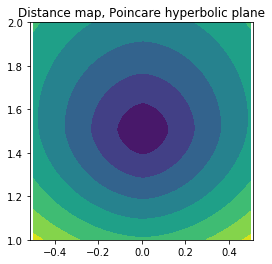

In [7]:
plt.figure(figsize=[4,4]); plt.title('Distance map, Poincare hyperbolic plane'); plt.axis('equal'); 
plt.contourf(X,Y,hfmOut['values']);

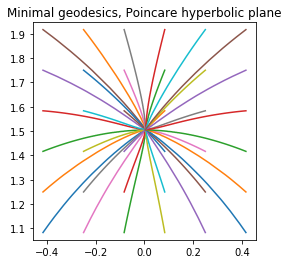

In [8]:
fig = plt.figure(figsize=[4,4]); plt.title('Minimal geodesics, Poincare hyperbolic plane'); plt.axis('equal'); 
for geo in HFMUtils.GetGeodesics(hfmOut):  plt.plot(geo[:,0],geo[:,1]) 

Next we compare the numerical results with the analytic expression of the distance.

In [9]:
ExactSolution = PoincareDistance(hfmIn['seeds'][0],(X,Y))
def LInfNorm(a):
    return np.max(np.abs(a))
def L1Norm(a):
    return np.sum(np.abs(a))/a.size

In [10]:
print("Max error : ",LInfNorm(ExactSolution - hfmOut['values']) )
print("Average error : ", L1Norm(ExactSolution - hfmOut['values']) )

Max error :  0.014974751023088206
Average error :  0.0055575705831370096


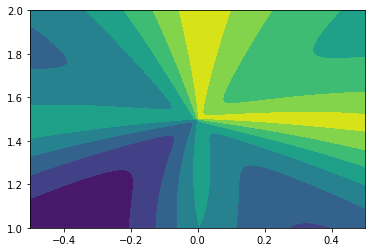

In [11]:
plt.contourf(X,Y,ExactSolution - hfmOut['values'])

### 1.1 The seedRadius key

In the above experiment with the Poincare model, as in most typical uses of the fast marching method we suspect, the seed point falls off the discretization grid. This results in a $\mathcal O(h)$ error, which can be corrected with the option **seedRadius**, with the following effects.

* **seedRadius** $= 0$ (default).  The seed is rounded to the nearest grid point, producing the largest error. This is however the only available option with e.g. non-holonomic models, for which no analytic approximation of the solution is available. In addition, this default can be required for some use cases involving automatic differentiation [link](http://nbviewer.jupyter.org/urls/rawgithub.com/Mirebeau/HFM_Python_Notebooks/master/A2_Sensitivity.ipynb)

* **seedRadius** $=r>0$. All the grid points $q$ within radius $r$, *measured in pixels*, of the provided seed $p_*$ are initialized with the seed values 
$$
    %v(q) := 
    u(p_*) + \frac 1 2 (F_{p_*}(q-p_*) + F_q(q-p_*)).
$$

* **seedRadius** $=r<0$. All the grid points $q$ within radius $|r|$ of the provided seeds are set as seeds, with the above value, as well as the points which can be reached in one step using the numerical scheme stencil.

<!---

* **spreadSeeds = 0**. The corners $q$ of the grid cell (square or cube) containing the provided seed point $p_*$ are used as seeds, with the seed values 


* **spreadSeeds = 1**. A few additional grid points are used as seeds, corresponding to one step of the fast marching scheme.

In the Poincare half plane instance, an error reduction by $20\%$ (resp $35\%$) is obtained by choosing $\mathbf {spreadSeeds}=0$ (resp. $\mathbf {spreadSeeds}=1$) instead of the default.
--->

A typical value, in two dimensions, is seedRadius $=1.5$.

In [12]:
hfmIn['seedRadius'] = 1.5

In [13]:
hfmOut = HFMUtils.Run(hfmIn)

Field verbosity defaults to 1
Field order defaults to 1
Field showProgress defaults to 0
Field factoringMethod defaults to None
Fast marching solver completed in 0.002638 s.
Field geodesicSolver defaults to Discrete
Field geodesicStep defaults to 0.25
Field geodesicWeightThreshold defaults to 0.001
Field geodesicVolumeBound defaults to 8.45
Field exportActiveNeighs defaults to 0
Field exportGeodesicFlow defaults to 0
Field exportActiveOffsets defaults to 0


In [14]:
print("Max error : ",LInfNorm(ExactSolution - hfmOut['values']) )
print("Average error : ", L1Norm(ExactSolution - hfmOut['values']) )

# The four grid points enclosing the provided seed are used
print("spreadedSeeds", hfmOut['spreadedSeeds'])

Max error :  0.01024015982151194
Average error :  0.005398508223713217
spreadedSeeds [[ 0.00505051  1.50505051]
 [-0.00505051  1.49494949]
 [-0.00505051  1.50505051]
 [ 0.00505051  1.49494949]]


In [15]:
hfmIn['seedRadius'] = -1.5

In [16]:
hfmOut = HFMUtils.Run(hfmIn)

Field verbosity defaults to 1
Field order defaults to 1
Field showProgress defaults to 0
Field factoringMethod defaults to None
Fast marching solver completed in 0.002464 s.
Field geodesicSolver defaults to Discrete
Field geodesicStep defaults to 0.25
Field geodesicWeightThreshold defaults to 0.001
Field geodesicVolumeBound defaults to 8.45
Field exportActiveNeighs defaults to 0
Field exportGeodesicFlow defaults to 0
Field exportActiveOffsets defaults to 0


In [17]:
print("Max error : ",LInfNorm(ExactSolution - hfmOut['values']) )
print("Average error : ", L1Norm(ExactSolution - hfmOut['values']) )

# Twelve grid points are used, around the provided seed
print("spreadedSeeds : ", hfmOut['spreadedSeeds'])
print("spreadedSeedValues : ", hfmOut['spreadedSeedValues'])

Max error :  0.009375865003666828
Average error :  0.004553988978738238
spreadedSeeds :  [[ 0.00505051  1.50505051]
 [-0.00505051  1.49494949]
 [-0.00505051  1.50505051]
 [ 0.00505051  1.49494949]
 [-0.01515152  1.49494949]
 [-0.00505051  1.48484848]
 [-0.01515152  1.50505051]
 [-0.00505051  1.51515152]
 [ 0.00505051  1.48484848]
 [ 0.01515152  1.49494949]
 [ 0.00505051  1.51515152]
 [ 0.01515152  1.50505051]]
spreadedSeedValues :  [0.00475367 0.00476971 0.00475367 0.00476971 0.01066539 0.01070172
 0.01062953 0.01059416 0.01070172 0.01066539 0.01059416 0.01062953]


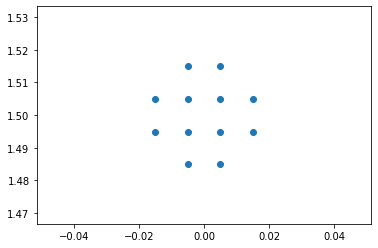

In [18]:
plt.axis('equal')
plt.scatter(hfmOut['spreadedSeeds'][:,0],hfmOut['spreadedSeeds'][:,1]);

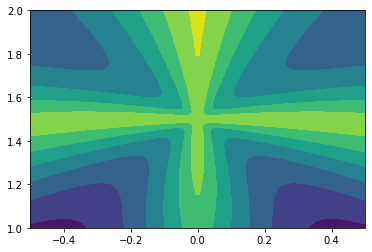

In [19]:
plt.contourf(X,Y,ExactSolution - hfmOut['values']);

### 1.2 (Static) Equation factoring

A substantial part of the numerical error of fast marching solvers is due to the singularity of the solution at the point source, which makes the finite differences inaccurate. In order to correct for this error, static factoring methods substract an analytical expression of the singularity from the numerical solution in the process of evaluating finite differences.

The parameters enabling this modification of the numerical scheme are the following:
* **factoringMethod** ('Static', 'None') Use 'Static' factoring to account for point source singularities. Default is 'None'.
* **factoringRadius** (in pixels, default is 20) Size of the region, around the seeds, where to use equation factoring. Factoring is often not performed in the entire domain, since it has a numerical cost, and it looses relevance once analytic expression isn't anymore a good approximation of the solution.
* **factoringPointChoice** ('Key', 'Current', 'Both'). Dictates the analytic expression of the solution used in equation factoring. 
    - 'Key' (Default) has the cheapest numerical cost, and yields the approximant
    $$
        %u(q) \approx 
        u(p_*) + F_{p_*}(q-p).
    $$
    - 'Current' yields the approximant 
    $$
        %u(q) \approx 
        u(p_*) + F_q (q-p).
    $$
    This is not an advised option, since it is slightly more expensive than 'Key' and not more accurate.
    - 'Both' yields the average of the previous two approximants. This option (one order) more accurate than the previous two. However, the difference is only visible when combined with high order schemes.

In [20]:
hfmIn.update({
    'factoringMethod':'Static',
    'factoringRadius':dimx*0.2, 
    'factoringPointChoice':'Key'
})

In [21]:
hfmOut = HFMUtils.Run(hfmIn)

Field verbosity defaults to 1
Field order defaults to 1
Field showProgress defaults to 0
Fast marching solver completed in 0.002586 s.
Field geodesicSolver defaults to Discrete
Field geodesicStep defaults to 0.25
Field geodesicWeightThreshold defaults to 0.001
Field geodesicVolumeBound defaults to 8.45
Field exportActiveNeighs defaults to 0
Field exportGeodesicFlow defaults to 0
Field exportActiveOffsets defaults to 0


In [22]:
print("Max error : ",LInfNorm(ExactSolution - hfmOut['values']) )
print("Average error : ", L1Norm(ExactSolution - hfmOut['values']) )

Max error :  0.004821634631043348
Average error :  0.0013539338011886912


Numerical error is considerably reduced in the factoring region, around the seed. The singularity is not anymore a source of error.
However, without a higher order scheme the overal error is not (much) reduced, since it is dominated by the regions far from the origin.

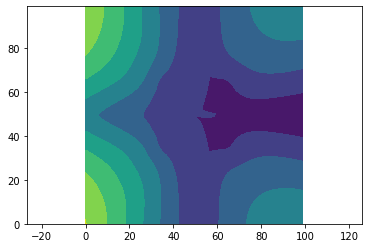

In [23]:
plt.axis('equal')
plt.contourf(hfmOut['values']-ExactSolution);

### 1.3 Second order scheme

The second order scheme is intended to reduce numerical error far from the solution singularity. It is complementary to the factorisation, discussed in the previous paragraph, which is devoted to the neighborhood of the source.

In [24]:
hfmIn['order']=2

In [25]:
hfmOut = HFMUtils.Run(hfmIn)

Field verbosity defaults to 1
Field showProgress defaults to 0
Fast marching solver completed in 0.003285 s.
Field geodesicSolver defaults to Discrete
Field geodesicStep defaults to 0.25
Field geodesicWeightThreshold defaults to 0.001
Field geodesicVolumeBound defaults to 8.45
Field exportActiveNeighs defaults to 0
Field exportGeodesicFlow defaults to 0
Field exportActiveOffsets defaults to 0


The overall numerical error is strongly reduced, by a factor 20 to 40 in this instance, in respectively $L^\infty$ or $L^1$ norm.

In [26]:
print("Max error : ",LInfNorm(ExactSolution - hfmOut['values']) )
print("Average error : ", L1Norm(ExactSolution - hfmOut['values']) )

Max error :  0.00031159216527232303
Average error :  8.846668969392208e-05


The second order scheme is much less efficient when it is not combined with equation factoring. 

In [27]:
hfmIn['factoringMethod']='None'

In [28]:
hfmOut = HFMUtils.Run(hfmIn)

Field verbosity defaults to 1
Field showProgress defaults to 0
Fast marching solver completed in 0.003524 s.
Field geodesicSolver defaults to Discrete
Field geodesicStep defaults to 0.25
Field geodesicWeightThreshold defaults to 0.001
Field geodesicVolumeBound defaults to 8.45
Field exportActiveNeighs defaults to 0
Field exportGeodesicFlow defaults to 0
Field exportActiveOffsets defaults to 0
***** Warning ! *****
Unused fields from user: factoringPointChoice factoringRadius 
********************


In [29]:
print("Max error : ",LInfNorm(ExactSolution - hfmOut['values']) )
print("Average error : ", L1Norm(ExactSolution - hfmOut['values']) )

Max error :  0.0022531467146763573
Average error :  0.0009527399338253569


In [30]:
hfmIn['factoringMethod']='Static'

### 1.4 Third order scheme, and semi-Lagrangian numerical methods

The second order scheme is expected, combined with point source factorisation, is expected to be accurate enough for most applications. However, as an experimental feature, a third order scheme is implemented as well.

**Strict causality** According to our numerical experiments, third order accuracy is however only achieved with a *strictly causal* scheme. This is an issue, since the Eulerian implementation of the eikonal equation is only *weakly causal*.


**Semi-Lagrangian schemes** 
These schemes are based on a discretization of Bellman's optimality principle, and by an adequate choice of discretization stencil, do obey a strict causality property. 
We emulate an isotropic metric as a special case of a Rander metric, which is implemented using a strictly causal semi-Lagrangian scheme in the HFM-Library. See the relevant notebook [A III, Rander metrics](http://nbviewer.jupyter.org/urls/rawgithub.com/Mirebeau/HFM_Python_Notebooks/master/A6_Rande.ipynb) for details on this model.


**Accuracy of semi-Lagrangian schemes, second order**
Already with the second order scheme, the better angular resolution of the semi-Lagrangian scheme yields a substantial error reduction. Numerical error is cut by a factor 4 or 2, in the $L^\infty$ or $L^1$ norm respectively. Note however than the semi-Lagrangian scheme is more costly numerically.

In [31]:
Zero = np.zeros(X.shape)
hfmIn.update({
    'model':'Rander2',
    'metric':np.stack([1/Y**2,Zero,1/Y**2, # Tensor
                      Zero,Zero],2) # Vector
})
hfmIn.pop('cost',None)

array([[1.        , 0.99      , 0.98019802, ..., 0.50510204, 0.50253807,
        0.5       ],
       [1.        , 0.99      , 0.98019802, ..., 0.50510204, 0.50253807,
        0.5       ],
       [1.        , 0.99      , 0.98019802, ..., 0.50510204, 0.50253807,
        0.5       ],
       ...,
       [1.        , 0.99      , 0.98019802, ..., 0.50510204, 0.50253807,
        0.5       ],
       [1.        , 0.99      , 0.98019802, ..., 0.50510204, 0.50253807,
        0.5       ],
       [1.        , 0.99      , 0.98019802, ..., 0.50510204, 0.50253807,
        0.5       ]])

In [32]:
hfmOut = HFMUtils.Run(hfmIn)

Field verbosity defaults to 1
Field cosAngleMin defaults to 0.5
Field refineStencilAtWallBoundary defaults to 0
Field showProgress defaults to 0
Fast marching solver completed in 0.010656 s.
Field geodesicSolver defaults to Discrete
Field geodesicStep defaults to 0.25
Field geodesicWeightThreshold defaults to 0.001
Field geodesicVolumeBound defaults to 8.45
Field exportActiveNeighs defaults to 0
Field exportGeodesicFlow defaults to 0
Field exportActiveOffsets defaults to 0


In [33]:
print("Max error : ",LInfNorm(ExactSolution - hfmOut['values']) )
print("Average error : ", L1Norm(ExactSolution - hfmOut['values']) )

Max error :  9.995008785140813e-05
Average error :  2.7217201595932382e-05


A further error reduction is achieved by selecting the more accurate analytic factorisation. Error is cut by a factor 2 approximately.

In [34]:
hfmIn['factoringPointChoice']='Both'

In [35]:
hfmOut = HFMUtils.Run(hfmIn)

Field verbosity defaults to 1
Field cosAngleMin defaults to 0.5
Field refineStencilAtWallBoundary defaults to 0
Field showProgress defaults to 0
Fast marching solver completed in 0.01082 s.
Field geodesicSolver defaults to Discrete
Field geodesicStep defaults to 0.25
Field geodesicWeightThreshold defaults to 0.001
Field geodesicVolumeBound defaults to 8.45
Field exportActiveNeighs defaults to 0
Field exportGeodesicFlow defaults to 0
Field exportActiveOffsets defaults to 0


In [36]:
print("Max error : ",LInfNorm(ExactSolution - hfmOut['values']) )
print("Average error : ", L1Norm(ExactSolution - hfmOut['values']) )

Max error :  6.682988357259445e-05
Average error :  2.1174393272868224e-05


Finally, the smallest error is obtained with the third order scheme. Error is cut by a additional factor 7 approximately.

In [37]:
hfmIn['order']=3

In [38]:
hfmOut = HFMUtils.Run(hfmIn)

Field verbosity defaults to 1
Field cosAngleMin defaults to 0.5
Field refineStencilAtWallBoundary defaults to 0
Field showProgress defaults to 0
Fast marching solver completed in 0.011342 s.
Field geodesicSolver defaults to Discrete
Field geodesicStep defaults to 0.25
Field geodesicWeightThreshold defaults to 0.001
Field geodesicVolumeBound defaults to 8.45
Field exportActiveNeighs defaults to 0
Field exportGeodesicFlow defaults to 0
Field exportActiveOffsets defaults to 0


In [39]:
print("Max error : ",LInfNorm(ExactSolution - hfmOut['values']) )
print("Average error : ", L1Norm(ExactSolution - hfmOut['values']) )

Max error :  1.060822268889039e-05
Average error :  3.54673770152437e-06


Overall, in favorable cases, numerical error can be reduced by three orders of magnitude with the adequate  enhancements to the scheme.

In [40]:
print("LInf ratio : ", 0.014974751023088206/1.0486664716702343e-05)
print("L1 ratio : ", 0.0055575705831370096/3.2811874264378546e-06)


LInf ratio :  1427.9803376604182
L1 ratio :  1693.768096987516


## 2. A Riemannian metric

In this section, we demonstrate high order accuracy for Riemannian anisotropic fast marching. For that purpose we introduce a synthetic Riemannian metric which is the image by a diffeomorphism of an usual norm, so that an exact expression of the distance map is known. 

More precisely, consider the diffeomorphism defined at each point $p = (x,y)$ by 
$$
    f(x,y) := (x,y+ \sin(\pi x) /2)
$$
and the matrix $M$ of diagonal entries $(0.5^2,1)$. We let 
$$
    \mathcal M(p) := (Jf(p))^T \cdot M \cdot Jf(p),
$$
where $Jf(p)$ is the Jacobian matrix of $f$ at $p$. The distance between $p,q$ is thus 
$$
    d_{\mathcal M}(p,q) = \|f(p) - f(q)\|_M.
$$


In [41]:
def diff(x,y):
    return np.array([x,y+0.5*np.sin(np.pi*x)])
def JacDiff(x,y):
    zero = 0.*x
    return np.array([[1.+zero,zero],[0.5*np.pi*np.cos(np.pi*x),1.+zero]])

diagCoef = (0.5**2,1) #Diagonal coefficients
def RiemannMetric(x,y):
    J = JacDiff(x,y)
    a,b=diagCoef
    return np.array([[a*J[0,0]**2+b*J[1,0]**2, a*J[0,0]*J[0,1]+b*J[1,0]*J[1,1]],
                    [a*J[0,0]*J[0,1]+b*J[1,0]*J[1,1],a*J[0,1]**2+b*J[1,1]**2]])

The metric is rather strongly anisotropic, with ratio of larger than $7$ of the fastest to the smallest speed, at a given point, depending on the direction.

In [42]:
np.sqrt(np.linalg.cond(RiemannMetric(0,0)))

7.297774117194749

In [43]:
dimx=200
hfmIn = HFMUtils.Rect(sides=[[-1,1],[-0.5,0.5]],dimx=dimx)
hfmIn.update({
    'model':'Riemann2',
    'seeds':np.array([[0.,0.]]),
    'exportValues':1.,
    'arrayOrdering':'RowMajor',
    'tips':[[x,y] for x in HFMUtils.CenteredLinspace(-1,1,6) 
            for y in HFMUtils.CenteredLinspace(-0.5,0.5,6)],
    'geodesicSolver':'Discrete'
})

X,Y = HFMUtils.GetGrid(hfmIn)

In [44]:
metric = RiemannMetric(X,Y)
hfmIn['metric'] = Metrics.Riemann(metric).to_HFM() 

In [45]:
hfmOut = HFMUtils.Run(hfmIn)

Field verbosity defaults to 1
Field order defaults to 1
Field seedRadius defaults to 0
Field showProgress defaults to 0
Field factoringMethod defaults to None
Fast marching solver completed in 0.010435 s.
Field geodesicStep defaults to 0.25
Field geodesicWeightThreshold defaults to 0.001
Field geodesicVolumeBound defaults to 8.45
Field exportActiveNeighs defaults to 0
Field exportGeodesicFlow defaults to 0
Field exportActiveOffsets defaults to 0


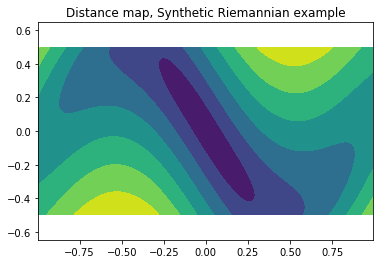

In [46]:
plt.title('Distance map, Synthetic Riemannian example'); plt.axis('equal')
plt.contourf(X,Y,hfmOut['values']);

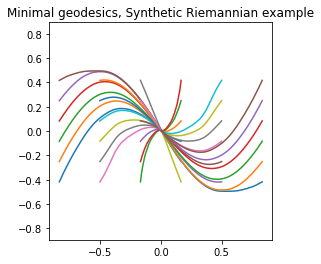

In [47]:
fig = plt.figure(figsize=[4,4]); plt.title('Minimal geodesics, Synthetic Riemannian example'); plt.axis('equal'); 
for geo in HFMUtils.GetGeodesics(hfmOut):  plt.plot(geo[:,0],geo[:,1]) 

The exact solution is, by design, explicit.

In [48]:
Xf,Yf = diff(X,Y)
a,b=diagCoef
ExactSolution = np.sqrt(a*Xf**2+b*Yf**2)

There are some shadow zones in the domain : the geodesics reaching these points, according to the exact model, should have gone outside the rectangle. Clearly, the numerical solution cannot agree with the exact solution on these points, which are thus removed from the error computation.

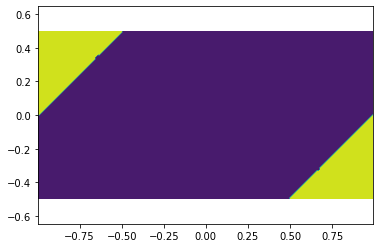

In [49]:
shadow = np.abs(X-Y)>=1
plt.axis('equal')
plt.contourf(X,Y,shadow);

In [50]:
error = ExactSolution - hfmOut['values']; error[shadow]=0.
print("Max error : ",LInfNorm(error) )
print("Average error : ", L1Norm(error) )

Max error :  0.02908883254421535
Average error :  0.009789067979843967


### 2.1 Trying the various numerical scheme enhancements

Spreading the seed information on the four adjacent pixels already cuts the error in half.

In [51]:
hfmIn['seedRadius']=1.5

hfmOut = HFMUtils.Run(hfmIn)
error = ExactSolution - hfmOut['values']; error[shadow]=0.
print("Max error : ",LInfNorm(error) )
print("Average error : ", L1Norm(error) )

Field verbosity defaults to 1
Field order defaults to 1
Field showProgress defaults to 0
Field factoringMethod defaults to None
Fast marching solver completed in 0.009091 s.
Field geodesicStep defaults to 0.25
Field geodesicWeightThreshold defaults to 0.001
Field geodesicVolumeBound defaults to 8.45
Field exportActiveNeighs defaults to 0
Field exportGeodesicFlow defaults to 0
Field exportActiveOffsets defaults to 0
Max error :  0.01687222010081446
Average error :  0.005061895743398188


Curiously, spreading the seed information a little further does not help, at all.
Note that the grid points used depend on the discretization stencil, which is here anisotropic.

**TODO**: inquire into this.

In [52]:
hfmIn['seedRadius']=-1.5

hfmOut = HFMUtils.Run(hfmIn)
error = ExactSolution - hfmOut['values']; error[shadow]=0.
print("Max error : ",LInfNorm(error) )
print("Average error : ", L1Norm(error) )

Field verbosity defaults to 1
Field order defaults to 1
Field showProgress defaults to 0
Field factoringMethod defaults to None
Fast marching solver completed in 0.009387 s.
Field geodesicStep defaults to 0.25
Field geodesicWeightThreshold defaults to 0.001
Field geodesicVolumeBound defaults to 8.45
Field exportActiveNeighs defaults to 0
Field exportGeodesicFlow defaults to 0
Field exportActiveOffsets defaults to 0
Max error :  0.017551131842353573
Average error :  0.004929746282214542


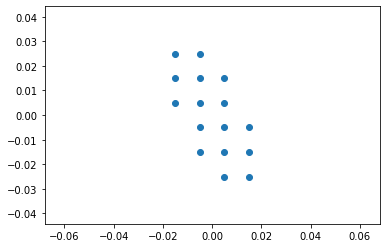

In [53]:
plt.axis('equal')
plt.scatter(hfmOut['spreadedSeeds'][:,0],hfmOut['spreadedSeeds'][:,1]);

Enabling equation factoring only helps, around the center.
Because the metric varies quickly, this technique does seem to add to the error in certain regions.

In [54]:
hfmIn['factoringMethod']='Static'
hfmIn['factoringRadius']=30

hfmOut = HFMUtils.Run(hfmIn)
error = ExactSolution - hfmOut['values']; error[shadow]=0.
print("Max error : ",LInfNorm(error) )
print("Average error : ", L1Norm(error) )

Field verbosity defaults to 1
Field order defaults to 1
Field showProgress defaults to 0
Field factoringPointChoice defaults to Key
Fast marching solver completed in 0.011234 s.
Field geodesicStep defaults to 0.25
Field geodesicWeightThreshold defaults to 0.001
Field geodesicVolumeBound defaults to 8.45
Field exportActiveNeighs defaults to 0
Field exportGeodesicFlow defaults to 0
Field exportActiveOffsets defaults to 0
Max error :  0.021531184376443857
Average error :  0.006062799287087411


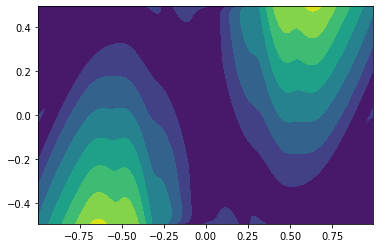

In [55]:
plt.contourf(X,Y,np.abs(error));

The second order scheme has a huge impact on accuracy. Errors are cut by a factor 10 to 40, in $L^\infty$ and $L^1$ respectively.

In [56]:
hfmIn['order']=2

hfmOut = HFMUtils.Run(hfmIn)
error = ExactSolution - hfmOut['values']; error[shadow]=0.
print("Max error : ",LInfNorm(error) )
print("Average error : ", L1Norm(error) )

Field verbosity defaults to 1
Field showProgress defaults to 0
Field factoringPointChoice defaults to Key
Fast marching solver completed in 0.013202 s.
Field geodesicStep defaults to 0.25
Field geodesicWeightThreshold defaults to 0.001
Field geodesicVolumeBound defaults to 8.45
Field exportActiveNeighs defaults to 0
Field exportGeodesicFlow defaults to 0
Field exportActiveOffsets defaults to 0
Max error :  0.0016241373922856184
Average error :  0.00013173138938703396


The semi-Lagrangian scheme does help, particularly in the max norm.

In [57]:
hfmIn['model']='Rander2'
metric = RiemannMetric(X,Y)
hfmIn['metric']=np.stack([metric[0,0],metric[1,0],metric[1,1],0.*X,0.*X],2)

hfmOut = HFMUtils.Run(hfmIn)
error = ExactSolution - hfmOut['values']; error[shadow]=0.
print("Max error : ",LInfNorm(error) )
print("Average error : ", L1Norm(error) )

Field verbosity defaults to 1
Field cosAngleMin defaults to 0.5
Field refineStencilAtWallBoundary defaults to 0
Field showProgress defaults to 0
Field factoringPointChoice defaults to Key
Fast marching solver completed in 0.024855 s.
Field geodesicStep defaults to 0.25
Field geodesicWeightThreshold defaults to 0.001
Field geodesicVolumeBound defaults to 8.45
Field exportActiveNeighs defaults to 0
Field exportGeodesicFlow defaults to 0
Field exportActiveOffsets defaults to 0
Max error :  0.00035854589833778094
Average error :  0.00010191575350879494


The last two arrows for accuracy enhancement, namely accurate factorisation and the third order scheme, help only a little. The $L^1$ error is cut by a factor two or three, while the $L^\infty$ error actually increases a bit. This is due, we believe, to the strong anisotropy and the relatively modest resolution used. 

(Recall that stencils are larger in strongly anisotropic instances, which reduces the effective resolution in comparison with the isotropic test case.)

In [58]:
hfmIn['factoringPointChoice']='Both'

hfmOut = HFMUtils.Run(hfmIn)
error = ExactSolution - hfmOut['values']; error[shadow]=0.
print("Max error : ",LInfNorm(error) )
print("Average error : ", L1Norm(error) )

Field verbosity defaults to 1
Field cosAngleMin defaults to 0.5
Field refineStencilAtWallBoundary defaults to 0
Field showProgress defaults to 0
Fast marching solver completed in 0.030694 s.
Field geodesicStep defaults to 0.25
Field geodesicWeightThreshold defaults to 0.001
Field geodesicVolumeBound defaults to 8.45
Field exportActiveNeighs defaults to 0
Field exportGeodesicFlow defaults to 0
Field exportActiveOffsets defaults to 0
Max error :  0.00041360687578151367
Average error :  5.8140746251915706e-05


In [59]:
hfmIn['order']=3

hfmOut = HFMUtils.Run(hfmIn)
error = ExactSolution - hfmOut['values']; error[shadow]=0.
print("Max error : ",LInfNorm(error) )
print("Average error : ", L1Norm(error) )

Field verbosity defaults to 1
Field cosAngleMin defaults to 0.5
Field refineStencilAtWallBoundary defaults to 0
Field showProgress defaults to 0
Fast marching solver completed in 0.03369 s.
Field geodesicStep defaults to 0.25
Field geodesicWeightThreshold defaults to 0.001
Field geodesicVolumeBound defaults to 8.45
Field exportActiveNeighs defaults to 0
Field exportGeodesicFlow defaults to 0
Field exportActiveOffsets defaults to 0
Max error :  0.0004429314035048204
Average error :  3.9034041276995046e-05


In [60]:
print("LInf ratio : ", 0.02908883254421535/0.0004451630035827159)
print("L1 ratio : ", 0.009789067979843967/3.436922647391891e-05)

LInf ratio :  65.34422741805933
L1 ratio :  284.8207243556209


## 3. A Rander metric

A Rander metric is, we recall, the sum of a Riemannian metric and a linear asymmetric perturbation. 
$$
    F_p(v) := \sqrt{v \cdot \mathcal M(p) \cdot v} + <\omega(p), v>.
$$
The perturbation is subject to a smallness condition: for each point $p$
$$
    \omega(p) \cdot \mathcal M(p)^{-1} \cdot \omega(p) < 1.
$$
In the special case where $\omega$ is a gradient field, the Riemannian distance and the Rander distance obey a simple relation:
$$
    d_F(p,q) = d_{\mathcal M}(p,q) + v(q)-v(p),
$$
if $\omega = \nabla v$.
We rely on this identity to build a synthetic test case with an explicit solution.

Let $\mathcal M\equiv M$ be constant, and $\omega = \gamma \nabla v$, with
$$
\begin{aligned}
    M &= \begin{pmatrix} 1.25 & 0.5 \\ 0.5 & 2 \end{pmatrix}, &
    v(x,y) &= \gamma \sin(\pi x) \sin(\pi y) / \pi,
\end{aligned}
$$
and $\gamma = 0.8$. Note that the smallness condition requires $|\gamma|<1$.


In [61]:
gamma = 0.8
def v(x,y):
    return gamma*np.sin(np.pi*x)*np.sin(np.pi*y)/np.pi
def omega(x,y):
    return gamma*np.array([np.cos(np.pi*x)*np.sin(np.pi*y),
                          np.sin(np.pi*x)*np.cos(np.pi*y)])
M = np.array([[1.25,0.5],[0.5,2.]])

In [62]:
np.linalg.eig(M)
# The worst anisotropy ratio will be approx 9, 
# occuring when omega is aligned with the small eigenvector.

(array([1.  , 2.25]), array([[-0.89442719, -0.4472136 ],
        [ 0.4472136 , -0.89442719]]))

In [63]:
dimx=200
hfmIn = HFMUtils.Rect(sides=[[-2,2],[-2,2]],dimx=dimx)
hfmIn.update({
    'model':'Rander2',
    'seeds':np.array([[0.,0.]]),
    'exportValues':1.,
    'arrayOrdering':'RowMajor',
    'tips':[[x,y] for x in HFMUtils.CenteredLinspace(-1,1,6) 
            for y in HFMUtils.CenteredLinspace(-1,1,6)],
})

X,Y = HFMUtils.GetGrid(hfmIn)
zero = 0.*X
omegaX,omegaY = omega(X,Y)
hfmIn['metric']=np.stack([M[0,0]+zero, M[1,0]+zero, M[1,1]+zero,
                         omegaX, omegaY],2)

In [64]:
hfmOut = HFMUtils.Run(hfmIn)

Field verbosity defaults to 1
Field cosAngleMin defaults to 0.5
Field refineStencilAtWallBoundary defaults to 0
Field order defaults to 1
Field seedRadius defaults to 0
Field showProgress defaults to 0
Field factoringMethod defaults to None
Fast marching solver completed in 0.055289 s.
Field geodesicSolver defaults to Discrete
Field geodesicStep defaults to 0.25
Field geodesicWeightThreshold defaults to 0.001
Field geodesicVolumeBound defaults to 8.45
Field exportActiveNeighs defaults to 0
Field exportGeodesicFlow defaults to 0
Field exportActiveOffsets defaults to 0


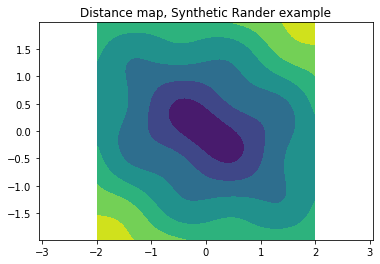

In [65]:
plt.title('Distance map, Synthetic Rander example'); plt.axis('equal')
plt.contourf(X,Y,hfmOut['values']);

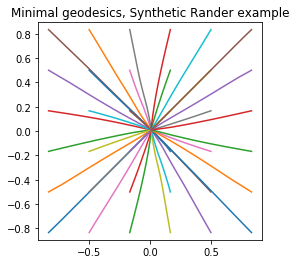

In [66]:
fig = plt.figure(figsize=[4,4]); plt.title('Minimal geodesics, Synthetic Rander example'); plt.axis('equal'); 
for geo in HFMUtils.GetGeodesics(hfmOut):  plt.plot(geo[:,0],geo[:,1]) 

In [67]:
ExactSolution = np.sqrt(M[0,0]*X**2+2*M[1,0]*X*Y+M[1,1]*Y**2)+v(X,Y)
shadow = X>=1.9

In [68]:
print("Max error : ",LInfNorm(ExactSolution - hfmOut['values']) )
print("Average error : ", L1Norm(ExactSolution - hfmOut['values']) )

Max error :  0.03476786943726218
Average error :  0.015537521580018856


**Trying the various enhancements.**
The *seedRadius* option has a significant impact, by eliminating a systematic $\mathcal O(h)$ error due to the seed approximation by a grid point. Factorisation is not much useful alone, since it acts only locally around the seed. However it enables higher order finite differences, which considerably reduce error.

In [69]:
hfmIn['seedRadius']=1.5

hfmOut = HFMUtils.Run(hfmIn)
print("Max error : ",LInfNorm(ExactSolution - hfmOut['values']) )
print("Average error : ", L1Norm(ExactSolution - hfmOut['values']) )

Field verbosity defaults to 1
Field cosAngleMin defaults to 0.5
Field refineStencilAtWallBoundary defaults to 0
Field order defaults to 1
Field showProgress defaults to 0
Field factoringMethod defaults to None
Fast marching solver completed in 0.048507 s.
Field geodesicSolver defaults to Discrete
Field geodesicStep defaults to 0.25
Field geodesicWeightThreshold defaults to 0.001
Field geodesicVolumeBound defaults to 8.45
Field exportActiveNeighs defaults to 0
Field exportGeodesicFlow defaults to 0
Field exportActiveOffsets defaults to 0
Max error :  0.01862454350767706
Average error :  0.006593869473545278


In [70]:
hfmIn['factoringMethod']='Static'
hfmIn['factoringRadius']=20

hfmOut = HFMUtils.Run(hfmIn)
print("Max error : ",LInfNorm(ExactSolution - hfmOut['values']) )
print("Average error : ", L1Norm(ExactSolution - hfmOut['values']) )

Field verbosity defaults to 1
Field cosAngleMin defaults to 0.5
Field refineStencilAtWallBoundary defaults to 0
Field order defaults to 1
Field showProgress defaults to 0
Field factoringPointChoice defaults to Key
Fast marching solver completed in 0.054077 s.
Field geodesicSolver defaults to Discrete
Field geodesicStep defaults to 0.25
Field geodesicWeightThreshold defaults to 0.001
Field geodesicVolumeBound defaults to 8.45
Field exportActiveNeighs defaults to 0
Field exportGeodesicFlow defaults to 0
Field exportActiveOffsets defaults to 0
Max error :  0.014465293015032632
Average error :  0.005119960502651063


In [71]:
hfmIn['order']=2

hfmOut = HFMUtils.Run(hfmIn)
print("Max error : ",LInfNorm(ExactSolution - hfmOut['values']) )
print("Average error : ", L1Norm(ExactSolution - hfmOut['values']) )

Field verbosity defaults to 1
Field cosAngleMin defaults to 0.5
Field refineStencilAtWallBoundary defaults to 0
Field showProgress defaults to 0
Field factoringPointChoice defaults to Key
Fast marching solver completed in 0.058957 s.
Field geodesicSolver defaults to Discrete
Field geodesicStep defaults to 0.25
Field geodesicWeightThreshold defaults to 0.001
Field geodesicVolumeBound defaults to 8.45
Field exportActiveNeighs defaults to 0
Field exportGeodesicFlow defaults to 0
Field exportActiveOffsets defaults to 0
Max error :  0.007599526776889132
Average error :  0.0008802922089513765


In [72]:
hfmIn['factoringPointChoice']='Both'

hfmOut = HFMUtils.Run(hfmIn)
print("Max error : ",LInfNorm(ExactSolution - hfmOut['values']) )
print("Average error : ", L1Norm(ExactSolution - hfmOut['values']) )

Field verbosity defaults to 1
Field cosAngleMin defaults to 0.5
Field refineStencilAtWallBoundary defaults to 0
Field showProgress defaults to 0
Fast marching solver completed in 0.060265 s.
Field geodesicSolver defaults to Discrete
Field geodesicStep defaults to 0.25
Field geodesicWeightThreshold defaults to 0.001
Field geodesicVolumeBound defaults to 8.45
Field exportActiveNeighs defaults to 0
Field exportGeodesicFlow defaults to 0
Field exportActiveOffsets defaults to 0
Max error :  0.0059737361956551105
Average error :  0.000528577696979788


In [73]:
hfmIn['order']=3

hfmOut = HFMUtils.Run(hfmIn)
print("Max error : ",LInfNorm(ExactSolution - hfmOut['values']) )
print("Average error : ", L1Norm(ExactSolution - hfmOut['values']) )

Field verbosity defaults to 1
Field cosAngleMin defaults to 0.5
Field refineStencilAtWallBoundary defaults to 0
Field showProgress defaults to 0
Fast marching solver completed in 0.059248 s.
Field geodesicSolver defaults to Discrete
Field geodesicStep defaults to 0.25
Field geodesicWeightThreshold defaults to 0.001
Field geodesicVolumeBound defaults to 8.45
Field exportActiveNeighs defaults to 0
Field exportGeodesicFlow defaults to 0
Field exportActiveOffsets defaults to 0
Max error :  0.005617428005999958
Average error :  0.00016056926490763673


In [74]:
print("LInf ratio : ", 0.03476786943726218/0.006871137608516875)
print("L1 ratio : ", 0.015537521580015985/0.00015772991402875582)

LInf ratio :  5.0599873584494794
L1 ratio :  98.50713275088283


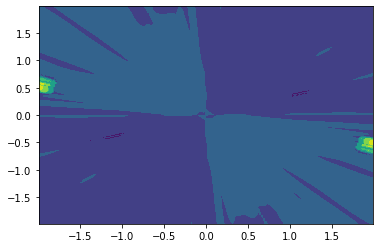

In [75]:
plt.contourf(X,Y,ExactSolution - hfmOut['values']);

## 4. Asymmetric quadratic metrics (TODO)

Results are somewhat similar to Rander metrics, with one substantial difference however: the solution is twice but not thrice differentiable. As a result, second order accuracy is the best one can hope for, and third order accuracy cannot be achieved.

## 5. Metric arising from seismology. (TODO)

The metrics considered in this section are defined in terms of a hooke tensor, representing the elastic properties of the ambient geological medium. Such models can be rotated and translated. However they are not affine invariant, in contrast with e.g. Riemannian, Rander, or asymmetric quadratic metrics considered above. 

We use a conformal change of coordinates, namely $z \mapsto z^2$, to produce an analytic example with a known solution.

In [76]:
def halfSquare(x,y):
    return 0.5*(x**2-y**2),x*y

In [77]:
dimx=200
hfmIn = HFMUtils.Rect([[1,3],[-1,1]],dimx=dimx)
hfmIn.update({
    'model':'Seismic2',
    'seeds':np.array([[2.,0.]]),
    'exportValues':1.,
    'arrayOrdering':'RowMajor',
    'tips':[[x,y] for x in HFMUtils.CenteredLinspace(1,3,6) 
            for y in HFMUtils.CenteredLinspace(-1,1,6)],
    
    'factoringMethod':'Static',
    'factoringPoints':[[0.1,0.2],[2.,0.001]],
})

X,Y = HFMUtils.GetGrid(hfmIn)
zero = 0.*X
Theta = np.arctan2(Y,X)

In [78]:
metric = Hooke.mica().extract_xz()
metric.rotate_by(Theta)
metric.hooke*=(X**2+Y**2)**2
metric.hooke.shape

(3, 3, 200, 200)

In [79]:
hfmIn['metric'] = metric.to_HFM() #np.transpose(HFMUtils.FlattenSymmetricMatrix(hooke),(1,2,0))

In [80]:
hfmOut = HFMUtils.Run(hfmIn)

Field verbosity defaults to 1
Field cosAngleMin defaults to 0.5
Field order defaults to 1
Field seedRadius defaults to 1
Field showProgress defaults to 0
Field factoringPointChoice defaults to Key
Field factoringRadius defaults to 10
Fast marching solver completed in 0.212567 s.
Field geodesicSolver defaults to Discrete
Field geodesicStep defaults to 0.25
Field geodesicWeightThreshold defaults to 0.001
Field geodesicVolumeBound defaults to 8.45
Field exportActiveNeighs defaults to 0
Field exportGeodesicFlow defaults to 0
Field exportActiveOffsets defaults to 0


In [81]:
hfmOut['factoringValues']

array([3.75253679e-02, 3.37398984e-05])